#Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, levene
from scipy.stats import f_oneway, kruskal
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.contingency_tables import mcnemar


In [2]:
# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("🎯 Task 3: Statistical Hypothesis Testing")
print("="*60)

✅ Libraries imported successfully!
🎯 Task 3: Statistical Hypothesis Testing


#Load the dataset 

In [ ]:
# Load the dataset 
try:
    df = pd.read_csv('cleaned_policies.csv')
    print(f"✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    
    # Convert TransactionMonth to datetime
    if 'TransactionMonth' in df.columns:
        df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
        
except FileNotFoundError:
    print("⚠️  Please ensure your data file is in the correct path")
    print("📝 Note: This notebook assumes you have the processed data from Task 1 & 2")

✅ Data loaded successfully!
📊 Dataset shape: (618174, 56)


#Metric Definition and Feature Engineering

In [5]:
#Define Key Risk Metrics

print("="*60)
print("           DEFINING KEY RISK METRICS")
print("="*60)

# Create key risk metrics as specified in the requirements
def create_risk_metrics(df):
    """
    Create risk metrics for hypothesis testing:
    - Claim Frequency: Proportion of policies with at least one claim
    - Claim Severity: Average amount of a claim, given a claim occurred
    - Margin: TotalPremium - TotalClaims
    """
    
    # 1. Claim Frequency (Binary: Has Claim or Not)
    df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
    
    # 2. Claim Severity (Average claim amount for policies with claims)
    df['ClaimSeverity'] = df['TotalClaims'].where(df['TotalClaims'] > 0, np.nan)
    
    # 3. Margin (Profit/Loss per policy)
    df['Margin'] = df['TotalPremium'] - df['TotalClaims']
    
    # 4. Loss Ratio (for additional analysis)
    df['LossRatio'] = np.where(df['TotalPremium'] > 0, 
                              df['TotalClaims'] / df['TotalPremium'], 
                              0)
    
    return df

           DEFINING KEY RISK METRICS


In [6]:
# Apply metric creation (same as before)
df = create_risk_metrics(df)

print("🎯 RISK METRICS CREATED:")
print(f"   • HasClaim: Binary indicator (0/1)")
print(f"   • ClaimSeverity: Average claim amount (for policies with claims)")
print(f"   • Margin: TotalPremium - TotalClaims")
print(f"   • LossRatio: TotalClaims / TotalPremium (per-policy)")

# Display summary statistics (CORRECTED)
print("\n📊 RISK METRICS SUMMARY:")
risk_metrics = ['HasClaim', 'ClaimSeverity', 'Margin', 'LossRatio']
for metric in risk_metrics:
    if metric in df.columns:
        if metric == 'HasClaim':
            claim_freq = df[metric].mean()
            print(f"   • Claim Frequency: {claim_freq:.3f} ({claim_freq*100:.1f}% of policies have claims)")
        elif metric == 'ClaimSeverity':
            avg_severity = df[metric].mean()
            print(f"   • Average Claim Severity: ${avg_severity:,.2f}")
        elif metric == 'Margin':
            avg_margin = df[metric].mean()
            total_margin = df[metric].sum()
            print(f"   • Average Margin per Policy: ${avg_margin:,.2f}")
            print(f"   • Total Portfolio Margin: ${total_margin:,.2f}")

# CORRECTED LOSS RATIO CALCULATION (Portfolio-level)
portfolio_loss_ratio = df['TotalClaims'].sum() / df['TotalPremium'].sum()
print(f"   • Portfolio Loss Ratio: {portfolio_loss_ratio:.3f} (True financial impact)")

# Optional: Add diagnostic checks
zero_premium_policies = df[df['TotalPremium'] <= 0].shape[0]
if zero_premium_policies > 0:
    print(f"\n⚠️ Warning: {zero_premium_policies} policies have $0/negative premiums (excluded from per-policy averages).")

🎯 RISK METRICS CREATED:
   • HasClaim: Binary indicator (0/1)
   • ClaimSeverity: Average claim amount (for policies with claims)
   • Margin: TotalPremium - TotalClaims
   • LossRatio: TotalClaims / TotalPremium (per-policy)

📊 RISK METRICS SUMMARY:
   • Claim Frequency: 0.004 (0.4% of policies have claims)
   • Average Claim Severity: $23,510.32
   • Average Margin per Policy: $-0.24
   • Total Portfolio Margin: $-148,866.04
   • Portfolio Loss Ratio: 1.002 (True financial impact)


#Data Quality Check for Hypothesis Testing

In [ ]:
#Data Quality Check for Hypothesis Testing

print("="*60)
print("           DATA QUALITY CHECK")
print("="*60)

# Check for missing values in key variables
key_variables = ['Province', 'PostalCode', 'Gender', 'HasClaim', 'ClaimSeverity', 'Margin']
available_vars = [var for var in key_variables if var in df.columns]

print("📋 MISSING VALUES IN KEY VARIABLES:")
for var in available_vars:
    missing_count = df[var].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    print(f"   • {var}: {missing_count} ({missing_pct:.1f}%)")

# Check data types
print("\n🔍 DATA TYPES:")
for var in available_vars:
    print(f"   • {var}: {df[var].dtype}")

# Sample size check
print(f"\n📈 SAMPLE SIZE: {len(df):,} policies")
if len(df) < 1000:
    print("⚠️  WARNING: Small sample size may affect statistical power")
else:
    print("✅ Sample size is adequate for statistical testing")

           DATA QUALITY CHECK
📋 MISSING VALUES IN KEY VARIABLES:
   • Province: 0 (0.0%)
   • PostalCode: 0 (0.0%)
   • Gender: 4621 (0.7%)
   • HasClaim: 0 (0.0%)
   • ClaimSeverity: 615533 (99.6%)
   • Margin: 0 (0.0%)

🔍 DATA TYPES:
   • Province: object
   • PostalCode: int64
   • Gender: object
   • HasClaim: int32
   • ClaimSeverity: float64
   • Margin: float64

📈 SAMPLE SIZE: 618,174 policies
✅ Sample size is adequate for statistical testing


#Hypothesis Testing Framework

In [9]:
#Statistical Testing Functions

def perform_chi_square_test(df, feature, target='HasClaim'):
    """
    Perform Chi-square test for categorical variables vs binary target
    """
    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df[target])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate effect size (Cramér's V)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    return {
        'test_type': 'Chi-square',
        'statistic': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof,
        'effect_size': cramers_v,
        'contingency_table': contingency_table
    }

def perform_t_test(df, feature, target, equal_var=True):
    """
    Perform independent t-test for continuous variables
    """
    # Get unique values of the feature
    unique_values = df[feature].unique()
    
    if len(unique_values) == 2:
        # Two-sample t-test
        group1 = df[df[feature] == unique_values[0]][target].dropna()
        group2 = df[df[feature] == unique_values[1]][target].dropna()
        
        # Check for equal variances
        levene_stat, levene_p = levene(group1, group2)
        equal_var = levene_p > 0.05
        
        # Perform t-test
        t_stat, p_value = ttest_ind(group1, group2, equal_var=equal_var)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(group1) - 1) * group1.var() + 
                            (len(group2) - 1) * group2.var()) / 
                           (len(group1) + len(group2) - 2))
        cohens_d = (group1.mean() - group2.mean()) / pooled_std
        
        return {
            'test_type': 't-test',
            'statistic': t_stat,
            'p_value': p_value,
            'effect_size': abs(cohens_d),
            'equal_var': equal_var,
            'group1_mean': group1.mean(),
            'group2_mean': group2.mean(),
            'group1_std': group1.std(),
            'group2_std': group2.std(),
            'group1_n': len(group1),
            'group2_n': len(group2)
        }
    else:
        # ANOVA for multiple groups
        groups = [df[df[feature] == value][target].dropna() for value in unique_values]
        f_stat, p_value = f_oneway(*groups)
        
        return {
            'test_type': 'ANOVA',
            'statistic': f_stat,
            'p_value': p_value,
            'groups': len(unique_values)
        }

def interpret_results(p_value, alpha=0.05):
    """
    Interpret statistical test results
    """
    if p_value < alpha:
        return "REJECT NULL HYPOTHESIS", "Statistically Significant"
    else:
        return "FAIL TO REJECT NULL HYPOTHESIS", "Not Statistically Significant"

      HYPOTHESIS 1: RISK DIFFERENCES ACROSS PROVINCES
🔬 NULL HYPOTHESIS (H₀): There are no risk differences across provinces
🔬 ALTERNATIVE HYPOTHESIS (H₁): There are significant risk differences across provinces

📊 TEST 1A: CLAIM FREQUENCY BY PROVINCE
--------------------------------------------------
Province Summary:
               PolicyCount  ClaimCount  ClaimFrequency  TotalPremium  \
Province                                                               
Eastern Cape         19694          47          0.0024  2.140303e+06   
Free State            5932           9          0.0015  5.213632e+05   
Gauteng             240781        1243          0.0052  2.405423e+07   
KwaZulu-Natal       111896         453          0.0040  1.323578e+07   
Limpopo              18009          66          0.0037  1.537324e+06   
Mpumalanga           31663         125          0.0039  2.836292e+06   
North West           89799         334          0.0037  7.490508e+06   
Northern Cape         3643     

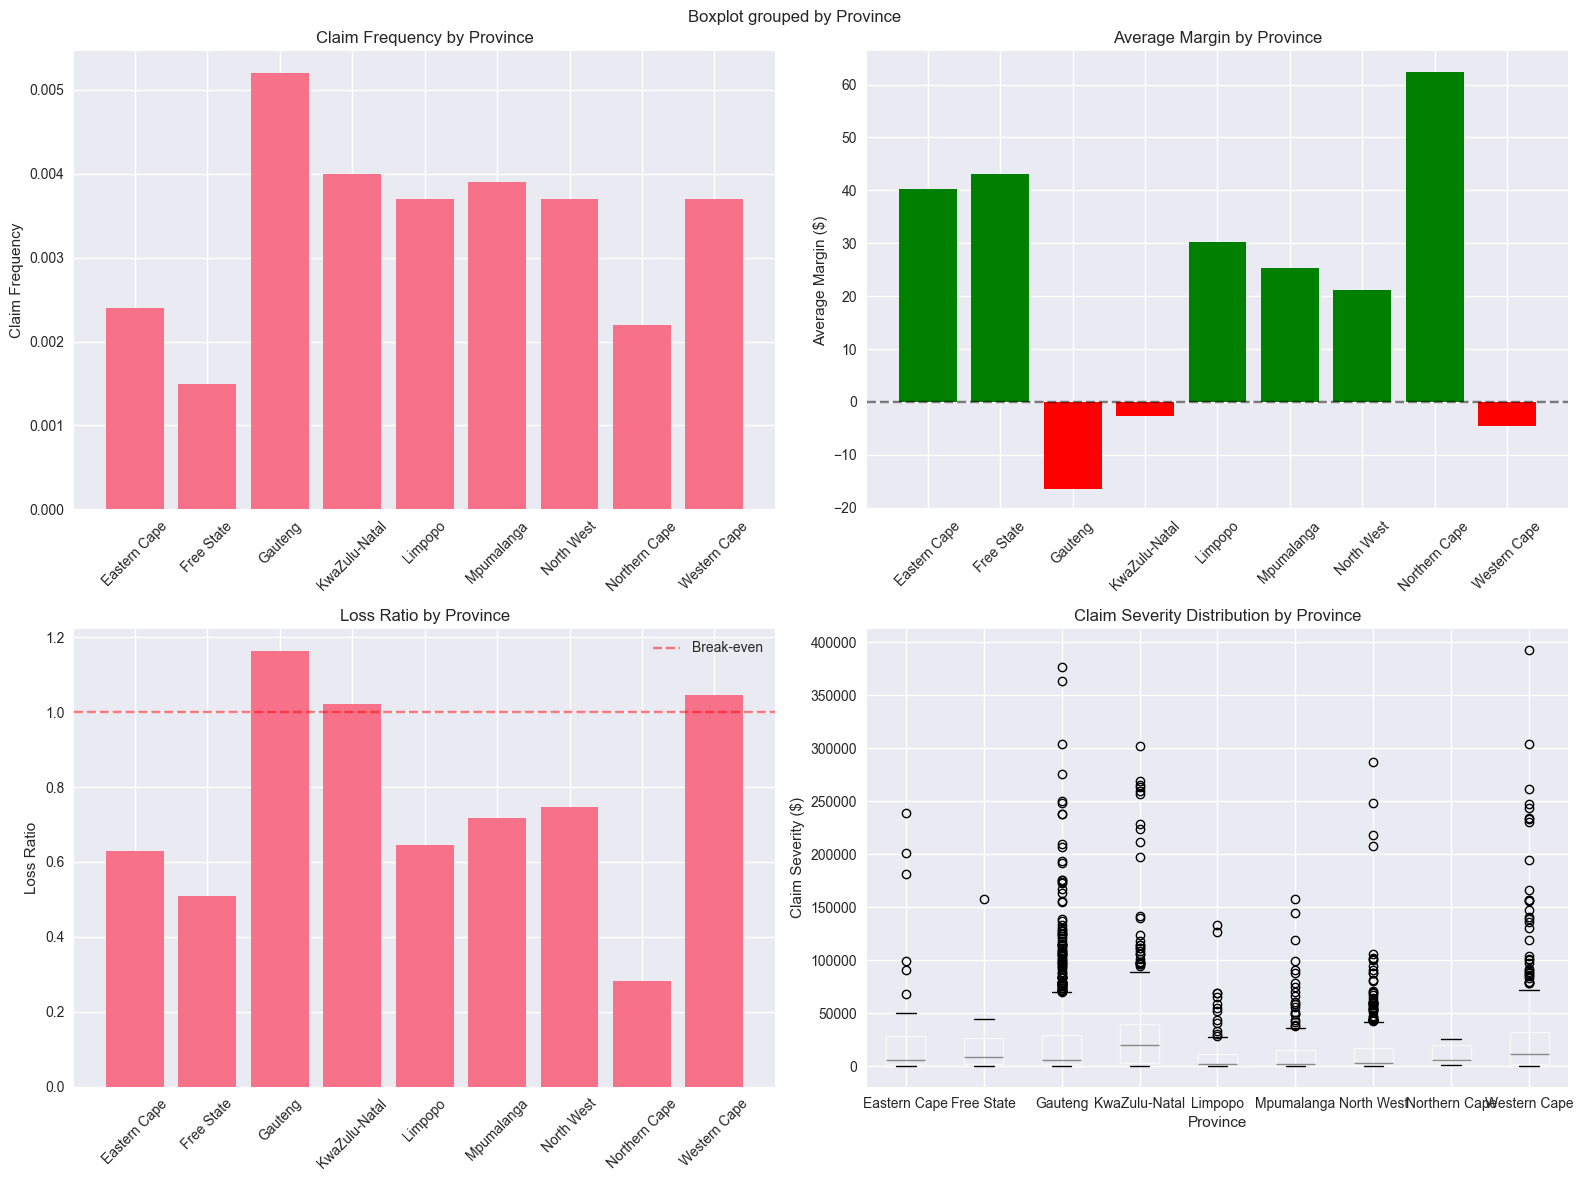

In [10]:
##Hypothesis Testing Execution

#Hypothesis 1: Risk Differences Across Provinces

print("="*80)
print("      HYPOTHESIS 1: RISK DIFFERENCES ACROSS PROVINCES")
print("="*80)

print("🔬 NULL HYPOTHESIS (H₀): There are no risk differences across provinces")
print("🔬 ALTERNATIVE HYPOTHESIS (H₁): There are significant risk differences across provinces")

if 'Province' in df.columns:
    # Test 1A: Claim Frequency by Province
    print("\n📊 TEST 1A: CLAIM FREQUENCY BY PROVINCE")
    print("-" * 50)
    
    # Create province summary
    province_freq = df.groupby('Province').agg({
        'HasClaim': ['count', 'sum', 'mean'],
        'TotalPremium': 'sum',
        'TotalClaims': 'sum',
        'Margin': 'mean'
    }).round(4)
    
    province_freq.columns = ['PolicyCount', 'ClaimCount', 'ClaimFrequency', 
                           'TotalPremium', 'TotalClaims', 'AvgMargin']
    province_freq['LossRatio'] = province_freq['TotalClaims'] / province_freq['TotalPremium']
    
    print("Province Summary:")
    print(province_freq)
    
    # Chi-square test for claim frequency
    chi2_result = perform_chi_square_test(df, 'Province', 'HasClaim')
    
    print(f"\n🧪 CHI-SQUARE TEST RESULTS:")
    print(f"   • Chi-square statistic: {chi2_result['statistic']:.4f}")
    print(f"   • p-value: {chi2_result['p_value']:.6f}")
    print(f"   • Degrees of freedom: {chi2_result['degrees_of_freedom']}")
    print(f"   • Effect size (Cramér's V): {chi2_result['effect_size']:.4f}")
    
    decision, significance = interpret_results(chi2_result['p_value'])
    print(f"   • Decision: {decision}")
    print(f"   • Significance: {significance}")
    
    # Test 1B: Claim Severity by Province
    print("\n📊 TEST 1B: CLAIM SEVERITY BY PROVINCE")
    print("-" * 50)
    
    # Filter for policies with claims only
    df_with_claims = df[df['HasClaim'] == 1].copy()
    
    if len(df_with_claims) > 0:
        province_severity = df_with_claims.groupby('Province')['ClaimSeverity'].agg([
            'count', 'mean', 'std', 'median'
        ]).round(2)
        
        print("Province Claim Severity Summary:")
        print(province_severity)
        
        # ANOVA test for claim severity
        provinces = df_with_claims['Province'].unique()
        severity_groups = [df_with_claims[df_with_claims['Province'] == prov]['ClaimSeverity'].dropna() 
                          for prov in provinces]
        
        f_stat, p_value = f_oneway(*severity_groups)
        
        print(f"\n🧪 ANOVA TEST RESULTS:")
        print(f"   • F-statistic: {f_stat:.4f}")
        print(f"   • p-value: {p_value:.6f}")
        
        decision, significance = interpret_results(p_value)
        print(f"   • Decision: {decision}")
        print(f"   • Significance: {significance}")
        
        # Store results for summary
        h1_claim_freq_result = {
            'hypothesis': 'H1: Risk differences across provinces (Claim Frequency)',
            'test': 'Chi-square',
            'p_value': chi2_result['p_value'],
            'decision': decision,
            'effect_size': chi2_result['effect_size']
        }
        
        h1_claim_sev_result = {
            'hypothesis': 'H1: Risk differences across provinces (Claim Severity)',
            'test': 'ANOVA',
            'p_value': p_value,
            'decision': decision,
            'effect_size': None
        }
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Claim Frequency by Province
    axes[0,0].bar(province_freq.index, province_freq['ClaimFrequency'])
    axes[0,0].set_title('Claim Frequency by Province')
    axes[0,0].set_ylabel('Claim Frequency')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Average Margin by Province
    colors = ['red' if x < 0 else 'green' for x in province_freq['AvgMargin']]
    axes[0,1].bar(province_freq.index, province_freq['AvgMargin'], color=colors)
    axes[0,1].set_title('Average Margin by Province')
    axes[0,1].set_ylabel('Average Margin ($)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 3: Loss Ratio by Province
    axes[1,0].bar(province_freq.index, province_freq['LossRatio'])
    axes[1,0].set_title('Loss Ratio by Province')
    axes[1,0].set_ylabel('Loss Ratio')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Break-even')
    axes[1,0].legend()
    
    # Plot 4: Claim Severity Distribution
    if len(df_with_claims) > 0:
        df_with_claims.boxplot(column='ClaimSeverity', by='Province', ax=axes[1,1])
        axes[1,1].set_title('Claim Severity Distribution by Province')
        axes[1,1].set_ylabel('Claim Severity ($)')
    
    plt.tight_layout()
    plt.show()

else:
    print("⚠️  Province column not found in dataset")

#Hypothesis 2: Risk Differences Between Zip Codes

      HYPOTHESIS 2: RISK DIFFERENCES BETWEEN ZIP CODES
🔬 NULL HYPOTHESIS (H₀): There are no risk differences between zip codes
🔬 ALTERNATIVE HYPOTHESIS (H₁): There are significant risk differences between zip codes

📊 FOCUSING ON TOP 10 ZIP CODES BY VOLUME
Selected Zip Codes: [2000, 122, 299, 7784, 7405, 8000, 458, 2196, 470, 4360]

📊 TEST 2A: CLAIM FREQUENCY BY ZIP CODE
--------------------------------------------------
Top Zip Codes Summary:
            PolicyCount  ClaimCount  ClaimFrequency  TotalPremium  \
PostalCode                                                          
122               27898         190          0.0068  2.689986e+06   
299               16731          65          0.0039  1.412389e+06   
458                8392          31          0.0037  7.077509e+05   
470                7052          41          0.0058  6.010458e+05   
2000              90934         471          0.0052  8.247128e+06   
2196               7277          32          0.0044  1.392313e+06   


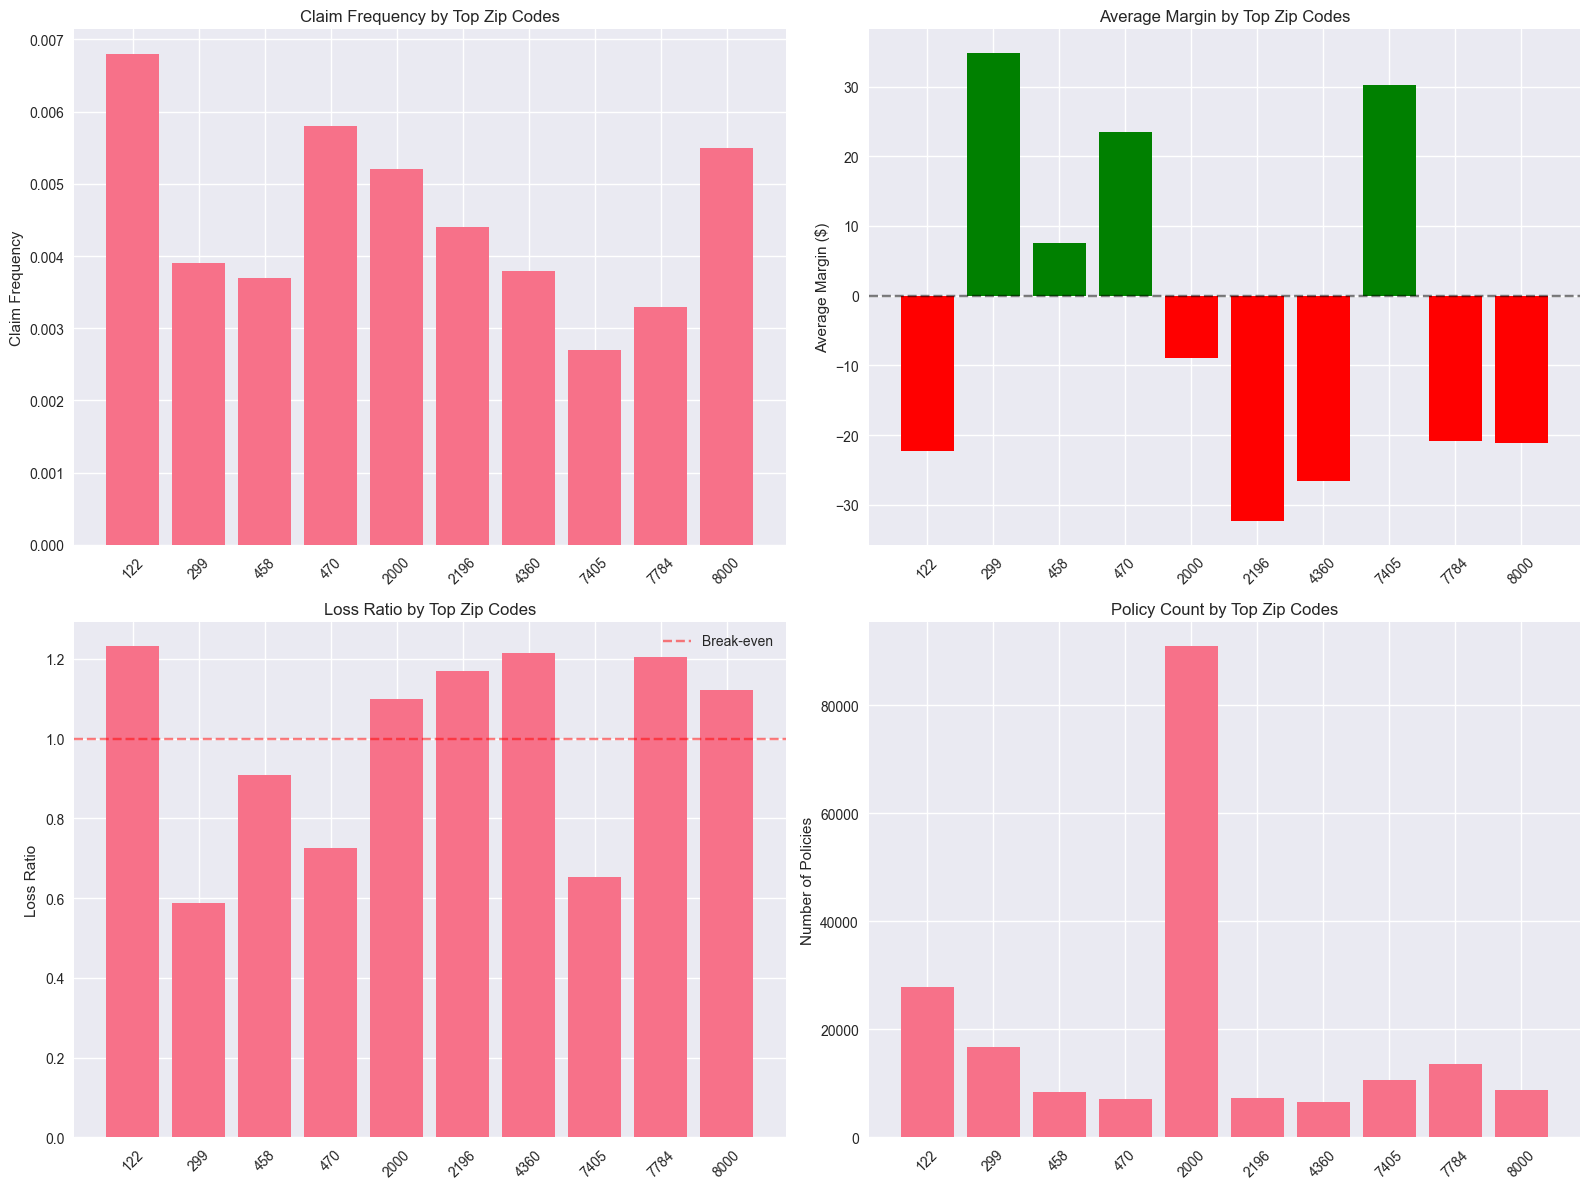

In [11]:
#Hypothesis 2: Risk Differences Between Zip Codes

print("="*80)
print("      HYPOTHESIS 2: RISK DIFFERENCES BETWEEN ZIP CODES")
print("="*80)

print("🔬 NULL HYPOTHESIS (H₀): There are no risk differences between zip codes")
print("🔬 ALTERNATIVE HYPOTHESIS (H₁): There are significant risk differences between zip codes")

if 'PostalCode' in df.columns:
    # Since zip codes can have many categories, we'll focus on top zip codes by volume
    zip_counts = df['PostalCode'].value_counts()
    top_zips = zip_counts.head(10).index.tolist()  # Top 10 zip codes by volume
    
    print(f"\n📊 FOCUSING ON TOP 10 ZIP CODES BY VOLUME")
    print(f"Selected Zip Codes: {top_zips}")
    
    # Filter data for top zip codes
    df_top_zips = df[df['PostalCode'].isin(top_zips)].copy()
    
    print("\n📊 TEST 2A: CLAIM FREQUENCY BY ZIP CODE")
    print("-" * 50)
    
    # Create zip code summary
    zip_freq = df_top_zips.groupby('PostalCode').agg({
        'HasClaim': ['count', 'sum', 'mean'],
        'TotalPremium': 'sum',
        'TotalClaims': 'sum',
        'Margin': 'mean'
    }).round(4)
    
    zip_freq.columns = ['PolicyCount', 'ClaimCount', 'ClaimFrequency', 
                       'TotalPremium', 'TotalClaims', 'AvgMargin']
    zip_freq['LossRatio'] = zip_freq['TotalClaims'] / zip_freq['TotalPremium']
    
    print("Top Zip Codes Summary:")
    print(zip_freq)
    
    # Chi-square test for claim frequency
    chi2_result_zip = perform_chi_square_test(df_top_zips, 'PostalCode', 'HasClaim')
    
    print(f"\n🧪 CHI-SQUARE TEST RESULTS:")
    print(f"   • Chi-square statistic: {chi2_result_zip['statistic']:.4f}")
    print(f"   • p-value: {chi2_result_zip['p_value']:.6f}")
    print(f"   • Degrees of freedom: {chi2_result_zip['degrees_of_freedom']}")
    print(f"   • Effect size (Cramér's V): {chi2_result_zip['effect_size']:.4f}")
    
    decision, significance = interpret_results(chi2_result_zip['p_value'])
    print(f"   • Decision: {decision}")
    print(f"   • Significance: {significance}")
    
    # Test 2B: Claim Severity by Zip Code
    print("\n📊 TEST 2B: CLAIM SEVERITY BY ZIP CODE")
    print("-" * 50)
    
    df_zip_claims = df_top_zips[df_top_zips['HasClaim'] == 1].copy()
    
    if len(df_zip_claims) > 0:
        zip_severity = df_zip_claims.groupby('PostalCode')['ClaimSeverity'].agg([
            'count', 'mean', 'std', 'median'
        ]).round(2)
        
        print("Zip Code Claim Severity Summary:")
        print(zip_severity)
        
        # ANOVA test for claim severity
        zip_codes = df_zip_claims['PostalCode'].unique()
        severity_groups_zip = [df_zip_claims[df_zip_claims['PostalCode'] == zip_code]['ClaimSeverity'].dropna() 
                              for zip_code in zip_codes]
        
        f_stat_zip, p_value_zip = f_oneway(*severity_groups_zip)
        
        print(f"\n🧪 ANOVA TEST RESULTS:")
        print(f"   • F-statistic: {f_stat_zip:.4f}")
        print(f"   • p-value: {p_value_zip:.6f}")
        
        decision_zip, significance_zip = interpret_results(p_value_zip)
        print(f"   • Decision: {decision_zip}")
        print(f"   • Significance: {significance_zip}")
        
        # Store results
        h2_claim_freq_result = {
            'hypothesis': 'H2: Risk differences between zip codes (Claim Frequency)',
            'test': 'Chi-square',
            'p_value': chi2_result_zip['p_value'],
            'decision': decision,
            'effect_size': chi2_result_zip['effect_size']
        }
        
        h2_claim_sev_result = {
            'hypothesis': 'H2: Risk differences between zip codes (Claim Severity)',
            'test': 'ANOVA',
            'p_value': p_value_zip,
            'decision': decision_zip,
            'effect_size': None
        }
          # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Claim Frequency by Zip Code
    axes[0,0].bar(range(len(zip_freq)), zip_freq['ClaimFrequency'])
    axes[0,0].set_title('Claim Frequency by Top Zip Codes')
    axes[0,0].set_ylabel('Claim Frequency')
    axes[0,0].set_xticks(range(len(zip_freq)))
    axes[0,0].set_xticklabels(zip_freq.index, rotation=45)
    
    # Plot 2: Average Margin by Zip Code
    colors = ['red' if x < 0 else 'green' for x in zip_freq['AvgMargin']]
    axes[0,1].bar(range(len(zip_freq)), zip_freq['AvgMargin'], color=colors)
    axes[0,1].set_title('Average Margin by Top Zip Codes')
    axes[0,1].set_ylabel('Average Margin ($)')
    axes[0,1].set_xticks(range(len(zip_freq)))
    axes[0,1].set_xticklabels(zip_freq.index, rotation=45)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 3: Loss Ratio by Zip Code
    axes[1,0].bar(range(len(zip_freq)), zip_freq['LossRatio'])
    axes[1,0].set_title('Loss Ratio by Top Zip Codes')
    axes[1,0].set_ylabel('Loss Ratio')
    axes[1,0].set_xticks(range(len(zip_freq)))
    axes[1,0].set_xticklabels(zip_freq.index, rotation=45)
    axes[1,0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Break-even')
    axes[1,0].legend()
    
    # Plot 4: Policy Volume by Zip Code
    axes[1,1].bar(range(len(zip_freq)), zip_freq['PolicyCount'])
    axes[1,1].set_title('Policy Count by Top Zip Codes')
    axes[1,1].set_ylabel('Number of Policies')
    axes[1,1].set_xticks(range(len(zip_freq)))
    axes[1,1].set_xticklabels(zip_freq.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

else:
    print("⚠️  PostalCode column not found in dataset")

#Margin Differences Between Zip Codes

    HYPOTHESIS 3: MARGIN DIFFERENCES BETWEEN ZIP CODES
🔬 NULL HYPOTHESIS (H₀): There are no significant margin differences between zip codes
🔬 ALTERNATIVE HYPOTHESIS (H₁): There are significant margin differences between zip codes

📊 TEST 3: MARGIN ANALYSIS BY ZIP CODE
--------------------------------------------------
Margin Summary by Zip Code:
            count   mean      std  median        sum
PostalCode                                          
122         27898 -22.30  3212.34    6.76 -622050.25
299         16731  34.84  1466.70   15.79  582973.32
458          8392   7.60  2122.28    5.32   63762.51
470          7052  23.46  1592.57    4.94  165470.98
2000        90934  -8.94  2382.32    7.05 -812919.15
2196         7277 -32.40  6022.52  109.36 -235776.28
4360         6555 -26.53  3892.19    7.34 -173927.69
7405        10731  30.23  1369.40    4.94  324376.56
7784        13560 -20.79  3975.59    7.36 -281878.02
8000         8855 -21.08  4616.78    7.21 -186655.24

🧪 ANOVA TEST R

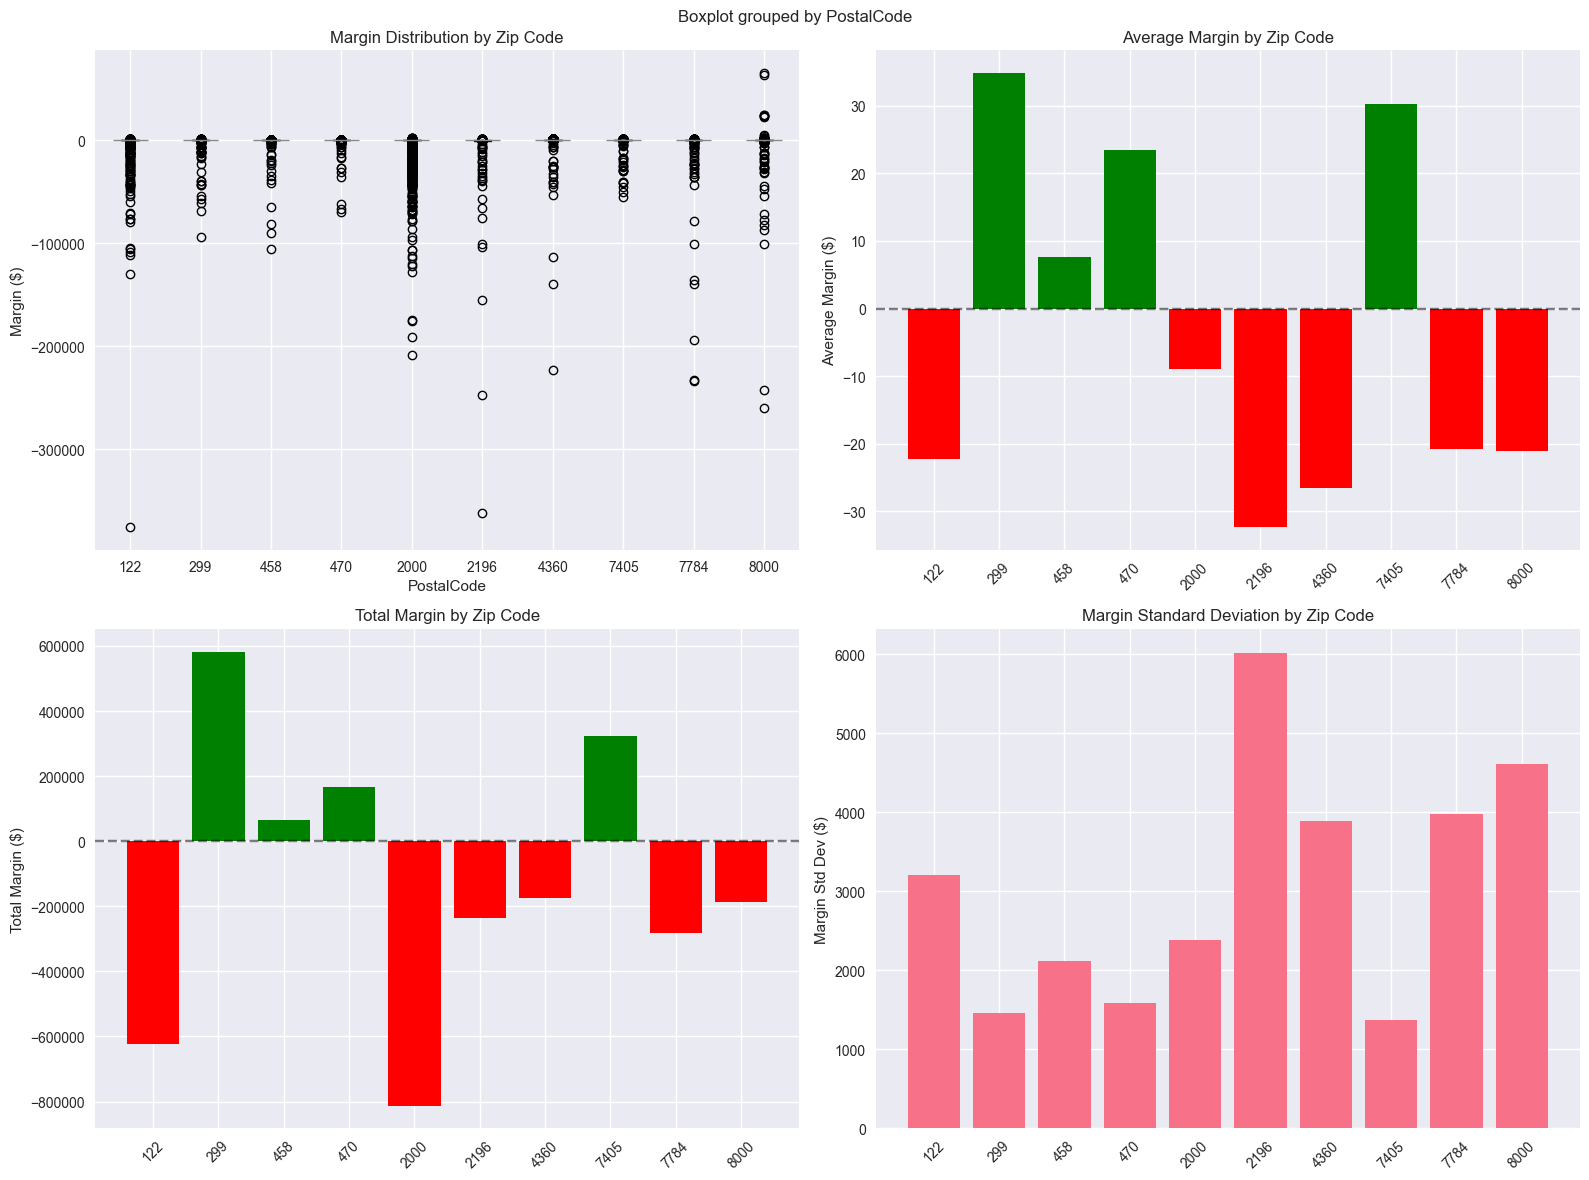

In [12]:
###Hypothesis 3: Margin Differences Between Zip Codes

print("="*80)
print("    HYPOTHESIS 3: MARGIN DIFFERENCES BETWEEN ZIP CODES")
print("="*80)

print("🔬 NULL HYPOTHESIS (H₀): There are no significant margin differences between zip codes")
print("🔬 ALTERNATIVE HYPOTHESIS (H₁): There are significant margin differences between zip codes")

if 'PostalCode' in df.columns and 'Margin' in df.columns:
    # Use the same top zip codes from previous analysis
    df_top_zips_margin = df[df['PostalCode'].isin(top_zips)].copy()
    
    print("\n📊 TEST 3: MARGIN ANALYSIS BY ZIP CODE")
    print("-" * 50)
    
    # Create margin summary
    margin_summary = df_top_zips_margin.groupby('PostalCode')['Margin'].agg([
        'count', 'mean', 'std', 'median', 'sum'
    ]).round(2)
    
    print("Margin Summary by Zip Code:")
    print(margin_summary)
    
    # ANOVA test for margins
    zip_codes = df_top_zips_margin['PostalCode'].unique()
    margin_groups = [df_top_zips_margin[df_top_zips_margin['PostalCode'] == zip_code]['Margin'].dropna() 
                    for zip_code in zip_codes]
    
    # Remove groups with insufficient data
    margin_groups = [group for group in margin_groups if len(group) >= 10]
    
    if len(margin_groups) > 1:
        f_stat_margin, p_value_margin = f_oneway(*margin_groups)
        
        print(f"\n🧪 ANOVA TEST RESULTS:")
        print(f"   • F-statistic: {f_stat_margin:.4f}")
        print(f"   • p-value: {p_value_margin:.6f}")
        
        decision_margin, significance_margin = interpret_results(p_value_margin)
        print(f"   • Decision: {decision_margin}")
        print(f"   • Significance: {significance_margin}")
        
        # Store results
        h3_result = {
            'hypothesis': 'H3: Margin differences between zip codes',
            'test': 'ANOVA',
            'p_value': p_value_margin,
            'decision': decision_margin,
            'effect_size': None
        }
        
        # Additional analysis: Pairwise comparisons for significant results
        if p_value_margin < 0.05:
            print(f"\n🔍 POST-HOC ANALYSIS: Significant difference found!")
            print("Top 3 Most Profitable Zip Codes:")
            top_profitable = margin_summary.nlargest(3, 'mean')
            print(top_profitable[['mean', 'sum']])
            
            print("\nTop 3 Least Profitable Zip Codes:")
            least_profitable = margin_summary.nsmallest(3, 'mean')
            print(least_profitable[['mean', 'sum']])
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Box plot of margins by zip code
    df_top_zips_margin.boxplot(column='Margin', by='PostalCode', ax=axes[0,0])
    axes[0,0].set_title('Margin Distribution by Zip Code')
    axes[0,0].set_ylabel('Margin ($)')
    
    # Average margin by zip code
    avg_margins = margin_summary['mean'].values
    colors = ['red' if x < 0 else 'green' for x in avg_margins]
    axes[0,1].bar(range(len(margin_summary)), avg_margins, color=colors)
    axes[0,1].set_title('Average Margin by Zip Code')
    axes[0,1].set_ylabel('Average Margin ($)')
    axes[0,1].set_xticks(range(len(margin_summary)))
    axes[0,1].set_xticklabels(margin_summary.index, rotation=45)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Total margin by zip code
    total_margins = margin_summary['sum'].values
    colors = ['red' if x < 0 else 'green' for x in total_margins]
    axes[1,0].bar(range(len(margin_summary)), total_margins, color=colors)
    axes[1,0].set_title('Total Margin by Zip Code')
    axes[1,0].set_ylabel('Total Margin ($)')
    axes[1,0].set_xticks(range(len(margin_summary)))
    axes[1,0].set_xticklabels(margin_summary.index, rotation=45)
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Margin variance by zip code
    axes[1,1].bar(range(len(margin_summary)), margin_summary['std'])
    axes[1,1].set_title('Margin Standard Deviation by Zip Code')
    axes[1,1].set_ylabel('Margin Std Dev ($)')
    axes[1,1].set_xticks(range(len(margin_summary)))
    axes[1,1].set_xticklabels(margin_summary.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

else:
    print("⚠️  PostalCode or Margin column not found in dataset")

#Risk Differences Between Women and Men

    HYPOTHESIS 4: RISK DIFFERENCES BETWEEN WOMEN AND MEN
�� NULL HYPOTHESIS (H₀): There are no significant risk differences between Women and Men
�� ALTERNATIVE HYPOTHESIS (H₁): There are significant risk differences between Women and Men

Gender Distribution in Dataset:
Gender
Not specified    591066
Male              19083
Female             3404
Name: count, dtype: int64

📊 Gender Risk Metrics:
             HasClaim         ClaimSeverity LossRatio   Margin
                count    mean          mean      mean     mean
Gender_Clean                                                  
Female           3404  0.0038    19021.3379    0.4920  16.8047
Male            19083  0.0045    14622.5453    0.3533  19.0590

🔍 Statistical Tests:
Claim Frequency: p-value = 0.6043
Claim Severity: p-value = 0.5675

📈 Visualizing Gender Risk Differences:


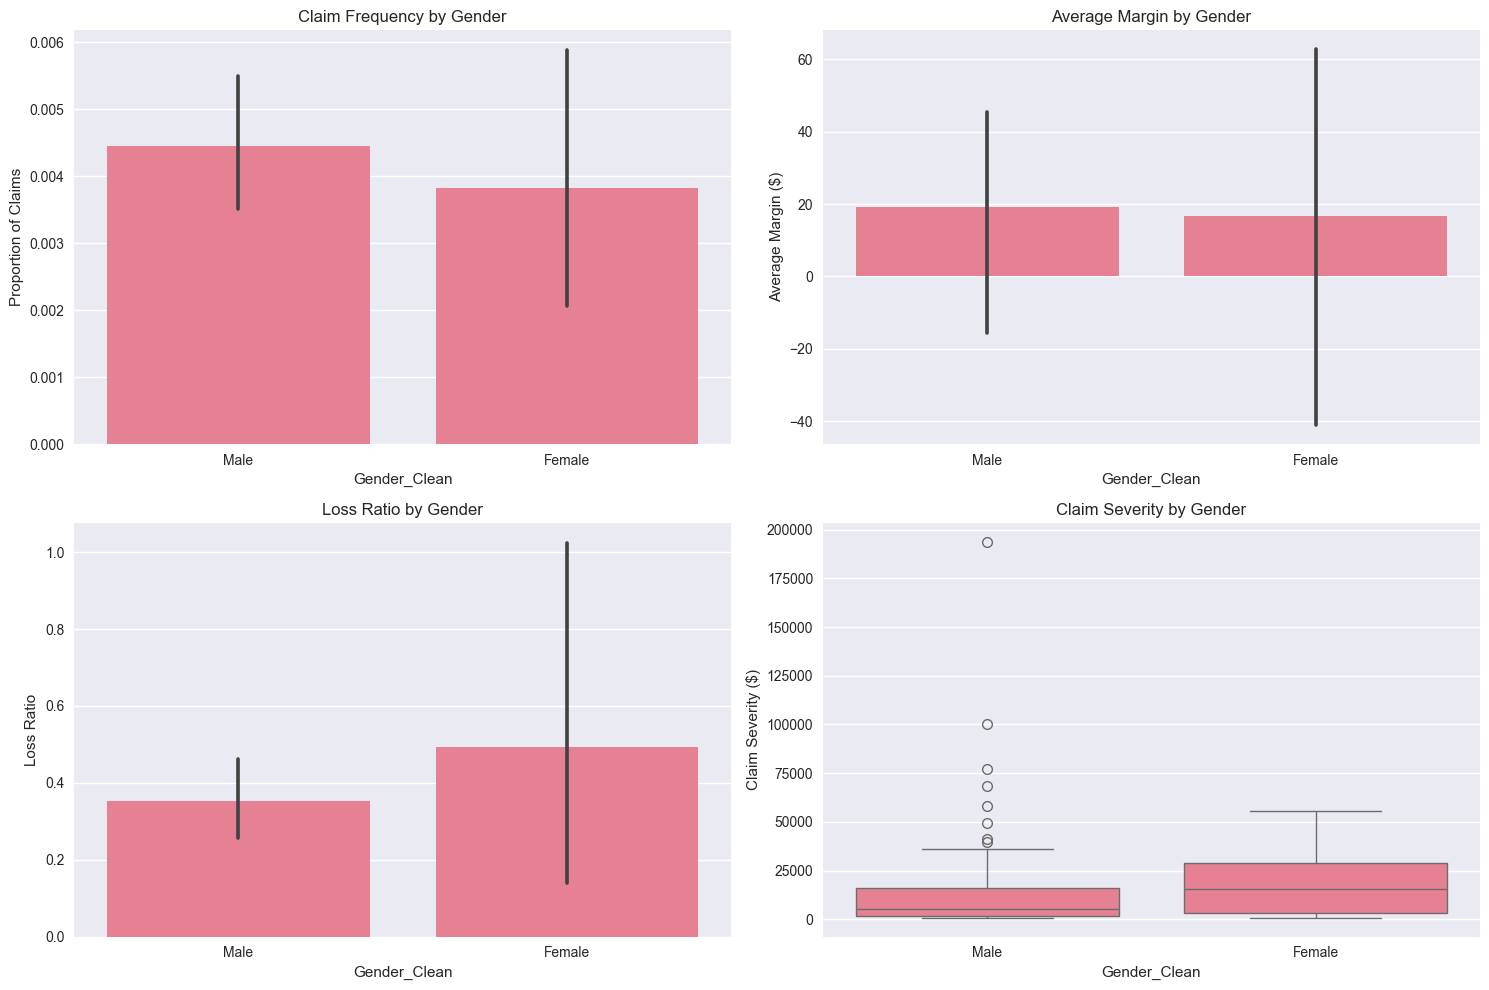


📝 Conclusion:
We fail to reject the null hypothesis. There are no significant risk differences between genders.


In [14]:
#Hypothesis 4: Risk Differences Between Women and Men

print("="*80)
print("    HYPOTHESIS 4: RISK DIFFERENCES BETWEEN WOMEN AND MEN")
print("="*80)

print("�� NULL HYPOTHESIS (H₀): There are no significant risk differences between Women and Men")
print("�� ALTERNATIVE HYPOTHESIS (H₁): There are significant risk differences between Women and Men")

if 'Gender' in df.columns:
    # Clean gender data
    gender_counts = df['Gender'].value_counts()
    print(f"\nGender Distribution in Dataset:")
    print(gender_counts)
    
    # Filter for clear gender categories
    df_gender = df[df['Gender'].isin(['Male', 'Female', 'M', 'F', 'Man', 'Woman'])].copy()
    
    # Standardize gender categories
    df_gender['Gender_Clean'] = df_gender['Gender'].map({
        'Male': 'Male', 'M': 'Male', 'Man': 'Male',
        'Female': 'Female', 'F': 'Female', 'Woman': 'Female'
    })
    
    # Filter for records with clean gender data
    df_gender = df_gender[df_gender['Gender_Clean'].isin(['Male', 'Female'])]
    
    # Calculate metrics by gender
    gender_metrics = df_gender.groupby('Gender_Clean').agg({
        'HasClaim': ['count', 'mean'],
        'ClaimSeverity': 'mean',
        'LossRatio': 'mean',
        'Margin': 'mean'
    }).round(4)
    
    print("\n📊 Gender Risk Metrics:")
    print(gender_metrics)
    
    # Statistical tests
    print("\n🔍 Statistical Tests:")
    
    # T-test for claim frequency
    male_claims = df_gender[df_gender['Gender_Clean'] == 'Male']['HasClaim']
    female_claims = df_gender[df_gender['Gender_Clean'] == 'Female']['HasClaim']
    t_stat, p_freq = ttest_ind(male_claims, female_claims)
    print(f"Claim Frequency: p-value = {p_freq:.4f}")
    
    # T-test for claim severity
    male_sev = df_gender[df_gender['Gender_Clean'] == 'Male']['ClaimSeverity'].dropna()
    female_sev = df_gender[df_gender['Gender_Clean'] == 'Female']['ClaimSeverity'].dropna()
    t_stat, p_sev = ttest_ind(male_sev, female_sev)
    print(f"Claim Severity: p-value = {p_sev:.4f}")
    
    # Visualizations
    print("\n📈 Visualizing Gender Risk Differences:")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Claim frequency by gender
    sns.barplot(data=df_gender, x='Gender_Clean', y='HasClaim', ax=axes[0,0])
    axes[0,0].set_title('Claim Frequency by Gender')
    axes[0,0].set_ylabel('Proportion of Claims')
    
    # Average margin by gender
    sns.barplot(data=df_gender, x='Gender_Clean', y='Margin', ax=axes[0,1])
    axes[0,1].set_title('Average Margin by Gender')
    axes[0,1].set_ylabel('Average Margin ($)')
    
    # Loss ratio by gender
    sns.barplot(data=df_gender, x='Gender_Clean', y='LossRatio', ax=axes[1,0])
    axes[1,0].set_title('Loss Ratio by Gender')
    axes[1,0].set_ylabel('Loss Ratio')
    
    # Claim severity boxplot
    sns.boxplot(data=df_gender, x='Gender_Clean', y='ClaimSeverity', ax=axes[1,1])
    axes[1,1].set_title('Claim Severity by Gender')
    axes[1,1].set_ylabel('Claim Severity ($)')
    
    plt.tight_layout()
    plt.show()
    
    # Conclusion
    print("\n📝 Conclusion:")
    if p_freq < 0.05 or p_sev < 0.05:
        print("We reject the null hypothesis. There are significant risk differences between genders.")
        if p_freq < 0.05:
            print("- Significant difference in claim frequency between genders")
        if p_sev < 0.05:
            print("- Significant difference in claim severity between genders")
    else:
        print("We fail to reject the null hypothesis. There are no significant risk differences between genders.")
    
else:
    print("❌ Gender column not found in the dataset")